In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

from Chempy.parameter import ModelParameters

import sbi.utils as utils
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.analysis import pairplot

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

In [8]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [9]:
# ----- Load the NN -----
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(elements))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x
    
model = Model_Torch()
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.eval();

In [17]:
local_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

global_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[:2]],
    validate_args=False)

In [24]:
N_stars = 200

stars = local_GP.sample((N_stars,))
global_params = global_GP.sample((1,))

stars = torch.cat((global_params.repeat(N_stars, 1), stars), dim=1)

In [26]:
# ----- Simulate abundances -----
abundances = model(stars)   

In [30]:
# ----- Load posterior -----
with open('data/posterior_SNPE_torch.pickle', 'rb') as f:
    posterior = pickle.load(f)

In [72]:
alpha_IMF = []
log10_N_Ia = []

for i in tqdm(range(len(abundances))):
    alpha, N_Ia = posterior.sample((1000,), x=abundances[i])[:,0:2].T
    alpha_IMF.append(alpha)
    log10_N_Ia.append(N_Ia)

alpha_IMF = np.array(alpha_IMF).ravel()
log10_N_Ia = np.array(log10_N_Ia).ravel()

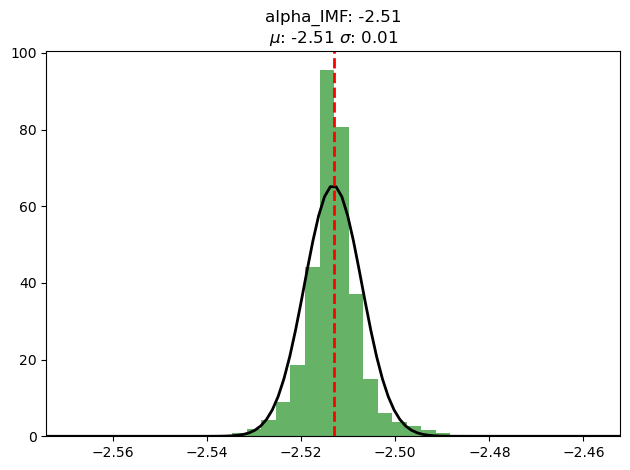

In [86]:
alpha_IMF_mean = np.mean(alpha_IMF)
alpha_IMF_std = np.std(alpha_IMF)
xmin = alpha_IMF_mean - 10*alpha_IMF_std
xmax = alpha_IMF_mean + 10*alpha_IMF_std

x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(alpha_IMF), np.std(alpha_IMF))

plt.hist(alpha_IMF, bins=100, density=True, alpha=0.6, color='g')
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(x=global_params[0][0], color='r', linestyle='dashed', linewidth=2)
plt.title(fr"alpha_IMF: {global_params[0][0]:.2f}"
                "\n"
                fr"$\mu$: {np.mean(alpha_IMF):.2f} $\sigma$: {np.std(alpha_IMF):.2f}")
plt.xlim(xmin, xmax)
plt.tight_layout()
plt.show()

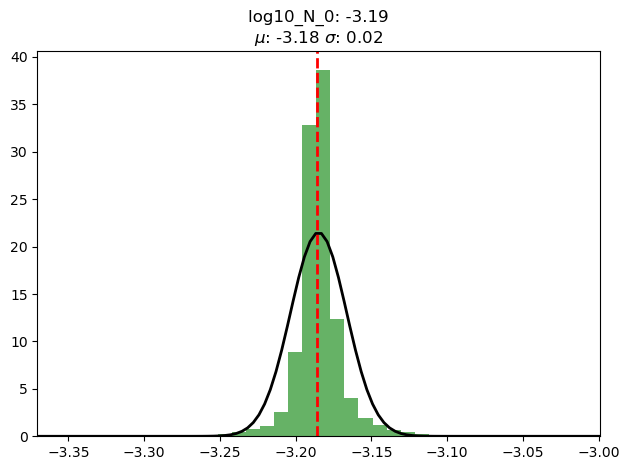

In [87]:
# same as above but for log10_N_Ia

log10_N_Ia_mean = np.mean(log10_N_Ia)
log10_N_Ia_std = np.std(log10_N_Ia)
xmin = log10_N_Ia_mean - 10*log10_N_Ia_std
xmax = log10_N_Ia_mean + 10*log10_N_Ia_std

x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(log10_N_Ia), np.std(log10_N_Ia))

plt.hist(log10_N_Ia, bins=100, density=True, alpha=0.6, color='g')
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(x=global_params[0][1], color='r', linestyle='dashed', linewidth=2)
plt.title(fr"log10_N_0: {global_params[0][1]:.2f}"
                "\n"
                fr"$\mu$: {np.mean(log10_N_Ia):.2f} $\sigma$: {np.std(log10_N_Ia):.2f}")
plt.xlim(xmin, xmax)
plt.tight_layout()
plt.show()